Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100) # let dataframes expand out all columns

Define a couple functions to create dummy variables for the subcategories. Shouldn't need to worry about these too much, they just put 1's under the columns of the subcategories the project falls under and 0's in the columns the project is not classified as.

In [2]:
def splitSubcat(df):
    df = df.copy()
    ext = [np.nan, np.nan]
    results = []
    for row in df['subcat_tree'].iteritems():
        if type(row[1]) is str:
            if ',' in row[1]:
                ext = list(map(lambda x: x.strip(), row[1].split(',')))
            else:
                ext[0] = row[1].strip()
                ext[1] = np.nan

            results.append([ext[0], ext[1]])
        else:
            results.append([np.nan, np.nan])
        
    results = pd.DataFrame(results, columns=['subcat_first', 'subcat_second'], index=df.index)
    print('Finished Splitting...')
    return df.merge(results, right_index=True, left_index=True).drop('subcat_tree', axis=1)

def sumSubcats(df, columns):
    df = df.copy()
    df2 = pd.get_dummies(df, prefix='s', columns=columns)
    cols, col_counts = np.unique(df2.columns.values, return_counts=True)
    for i, col in enumerate(cols):
        if col_counts[i] == 1:
            df[col] = df2[col]
        elif col_counts[i] > 1:
            df[col] = df2[col].sum(axis=1)
    return df

Import all the datasets.

In [3]:
schools_dat = pd.read_csv('data/data_clean/schools_clean.csv')
teachers_dat = pd.read_csv('data/data_clean/teachers_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv')

Take a random sample of $n=10000$ from the projects dataset. Merge this with schools, aligning `school_id`. Get rid of a few columns we don't care about (for the time being). Then create the dummy variables using the functions above.

In [4]:
sample = projects_notext_dat.sample(50000)
merge = sample.merge(teachers_dat, on='teacher_id').merge(schools_dat, on='school_id')
end = merge.drop(['proj_post_seq', 'proj_type', 'funded', 'posted', 'expire', 'first_project_posted'], axis=1)

In [5]:
cat_break = sumSubcats(splitSubcat(end), ['subcat_first', 'subcat_second'])

Finished Splitting...


Basically, clean the dataset so it's only 1's and 0's which we can compare. More info inline.

In [6]:
num_mat = cat_break.select_dtypes(np.number) # use only the numerical columns

num_mat = num_mat[num_mat['prefix'] > 0] # limit teacher prefix to only Mrs. and Mr.
num_mat['prefix'] = num_mat['prefix'] - 1 # reduce teacher prefix to only 1's and 0's

# we'll create four sets of dummy variables
metros = []
grades = []
costs = []
lunches = []
locations = []

num_mat.dropna(inplace=True) # get rid of rows that have one or more null values

for i, row in num_mat.iterrows():
    
    # iterate over each row in the subset thus far, we'll create dummy variables for each select feature
    
    # expand metropolitan type
    res = [0, 0, 0, 0, 0]
    if row['metro_type'] == 1:
        res[0] = 1 # rural
    elif row['metro_type'] == 2:
        res[1] = 1 # suburban
    elif row['metro_type'] == 3:
        res[2] = 1 # urban
    elif row['metro_type'] == 4:
        res[3] = 1 # town
    elif row['metro_type'] == 0:
        res[4] = 1 # ambiguous
        
    metros.append(np.array(res))
    
    # expand grade level
    res = [0, 0, 0, 0]
    if row['grade_level'] == 2:
        res[0] = 1
    elif row['grade_level'] == 3:
        res[1] = 1
    elif row['grade_level'] == 6:
        res[2] = 1
    elif row['grade_level'] == 9:
        res[3] = 1
        
    grades.append(np.array(res))
    
    # expand and bin the cost of the project
    res = [0, 0, 0, 0, 0, 0]
    if row['cost'] < 250:
        res[0] = 1
    elif row['cost'] < 500:
        res[1] = 1
    elif row['cost'] < 750:
        res[2] = 1
    elif row['cost'] < 1000:
        res[3] = 1
    elif row['cost'] < 1250:
        res[4] = 1
    elif row['cost'] >= 1250:
        res[5] = 1
        
    costs.append(np.array(res))
    
    # expand and bin the portion of students getting free lunch
    res = [0, 0, 0, 0]
    if row['free_lunch'] < 25:
        res[0] = 1
    elif row['free_lunch'] < 50:
        res[1] = 1
    elif row['free_lunch'] < 75:
        res[2] = 1
    elif row['free_lunch'] <= 100:
        res[3] = 1
        
    lunches.append(np.array(res))
    
    res = [0, 0, 0, 0, 0]
    if row['school_zip'] < 30000: #'East'
        res[0] = 1
    elif row['school_zip'] < 50000: #'Southeast'
        res[1] = 1
    elif row['school_zip'] < 80000: #'Mideast'
        res[2] = 1
    elif row['school_zip'] < 90000: #'Midwest'
        res[3] = 1
    else: #'West'
        res[4] = 1
        
    locations.append(np.array(res))
        
# merge all these dummy variables into the original matrix and get rid of the original columns
metros = pd.DataFrame(metros, columns=['rural', 'suburban', 'urban', 'town', 'ambiguous_metro'], index=num_mat.index)
grades = pd.DataFrame(grades, columns=['grade2', 'grade3', 'grade6', 'grade9'], index=num_mat.index)
costs = pd.DataFrame(costs, columns=['cost250', 'cost500', 'cost750', 'cost1000', 'cost1250', 'cost1250g'], index=num_mat.index)
lunches = pd.DataFrame(lunches, columns=['lunch25', 'lunch50', 'lunch75', 'lunch100'], index=num_mat.index)
locations = pd.DataFrame(locations, columns=['east', 'southeast', 'mideast', 'midwest', 'west'], index=num_mat.index)

num_mat = num_mat.merge(metros, left_index=True, right_index=True).drop('metro_type', axis=1)
num_mat = num_mat.merge(grades, left_index=True, right_index=True).drop('grade_level', axis=1)
num_mat = num_mat.merge(costs, left_index=True, right_index=True).drop('cost', axis=1)
num_mat = num_mat.merge(lunches, left_index=True, right_index=True).drop('free_lunch', axis=1)
num_mat = num_mat.merge(locations, left_index=True, right_index=True).drop('school_zip', axis=1)

print(num_mat.shape) # size of the matrix
num_mat.sample(5) # randoly sample 5

(31121, 56)


,status,prefix,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth,rural,suburban,urban,town,ambiguous_metro,grade2,grade3,grade6,grade9,cost250,cost500,cost750,cost1000,cost1250,cost1250g,lunch25,lunch50,lunch75,lunch100,east,southeast,mideast,midwest,west
5459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
28036,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
37965,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
11159,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
25899,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1


Compute a distance matrix. Every entry is the distance from the ith to the jth element.

https://link.springer.com/article/10.1007/BF00377169

https://stats.stackexchange.com/questions/61705/similarity-coefficients-for-binary-data-why-choose-jaccard-over-russell-and-rao

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

https://stats.stackexchange.com/questions/55798/what-is-the-optimal-distance-function-for-individuals-when-attributes-are-nomina/55802#55802

https://en.wikipedia.org/wiki/Jaccard_index

http://www.iiisci.org/journal/CV$/sci/pdfs/GS315JG.pdf

https://www.umass.edu/landeco/teaching/multivariate/readings/McCune.and.Grace.2002.chapter6.pdf

In [7]:
from scipy.spatial.distance import cdist

Y = cdist(num_mat, num_mat, 'jaccard') # 0 is completely similar, 1 is completely dissimilar

Sample the first 100 projects and visualize their similarity. 0 is completely similar, 1 is completely dissimilar.

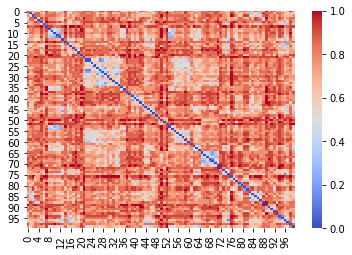

In [26]:
sns.heatmap(Y[:100, :100], cmap='coolwarm')
plt.savefig('jaccard_mat.png')

Sort each row by similarity (0 on the left, 1 on the right), and return the column j of each of those values

In [10]:
sort_Y = Y.argsort(axis=1)

Take the first two columns of the above (or, the reference project and its most similar project). Sort the n x 2 matrix on each row, putting the smaller number first. Get rid of any duplicates:

if the n x 2 matrix has both (0, 1234) and (1234, 0), once sorted they show up as (0, 1234) and (0, 1234) and we remove one of those instances.

In [11]:
unique_sort_Y = np.unique(np.sort(sort_Y[:, 0:2], axis=1), axis=0)

X-axis is the reference project "ID" (just the project's i value in the similarity matrix), y-axis is the similar project "ID" (the project's i value in the sim matrix too). Each dot represents a pair of similar projects. It should appear roughly uniform. Only upper triangle reported because we removed dups.

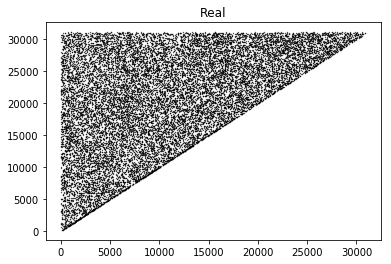

In [12]:
plt.title('Real')
plt.scatter(unique_sort_Y[:, 0], unique_sort_Y[:, 1], c='k', s=0.1)

Get actual project IDs from the merged project dataframe made in Cell 4.

In [13]:
ds = []
indices = []

for pair in unique_sort_Y:
    ds.append(Y[pair[0], pair[1]])
    
    ixs = num_mat.iloc[[pair[0], pair[1]], :].index
    indices.append(list(ixs))
    
    if pair[0] < 2:
        print('distance: {}\t({},{})'.format(Y[pair[0], pair[1]], pair[0], pair[1]))
        print(cat_break.loc[ixs])

indices = np.array(indices)

distance: 0.1111111111111111	(0,8014)
                             project_id                         school_id  \
0      192d29282acca3ab406dc182d2b8d085  1dca91d87f647008f96e41dc4761d311   
13103  68354f60d2dd91aa805b59184755127a  9d50a3fe0c49a36785dfb718ed371966   

                             teacher_id                             cat_tree  \
0      a56dcf74fc9d987653a920e638ad9f34  Literacy & Language, Math & Science   
13103  a9443312616da674b55d06dc3d11201c                  Literacy & Language   

       grade_level resource_cat    cost  status  prefix  \
0                2        Books  737.08       1       2   
13103            2        Books  527.16       1       2   

                      school_name  metro_type  free_lunch school_state  \
0      Magnolia Science Academy 2           3        74.0   California   
13103      Donald E Suburu School           3        65.0   California   

       school_zip  school_city school_county              school_district  \
0          

distance: 0.1111111111111111	(1,13152)
                             project_id                         school_id  \
4      ad8273736d2aaf23551f577f30bb38dd  4bec132856290f361daddbe8210e3097   
21457  c3168e64a6c1110ca357256e922fce28  a3824964d9b2ac1908ea9105b292bfa6   

                             teacher_id                             cat_tree  \
4      1ea4057ce8efa430e4e2865be2f0ae5d  Literacy & Language, Math & Science   
21457  aa5dd929d3d96d3d5b2352a2eafddc32                       Math & Science   

       grade_level resource_cat    cost  status  prefix  \
4                6     Supplies  324.11       1       2   
21457            6     Supplies  325.20       1       2   

                            school_name  metro_type  free_lunch school_state  \
4            Albert Sabin Magnet School           3        91.0     Illinois   
21457  William Carter Elementary School           3        95.0     Illinois   

       school_zip school_city school_county           school_district

Mean Jaccard similarity coefficient: 0.152
0.0995532633209


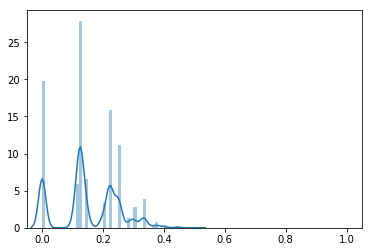

In [25]:
sns.distplot(ds, kde=True)
plt.xlim([-0.05, 1.05])
print('Mean Jaccard similarity coefficient: {:.3f}'.format(np.array(ds).mean()))
print(np.array(ds).std())

Mean Jaccard similarity coefficient is 0.217, on a scale from 0 to 1. Below that is a distribution of the similarity scores found by the algorithm.

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in ubyte_scalars
  return umr_sum(a, axis, dtype, out, keepdims)


0.61584207629901822

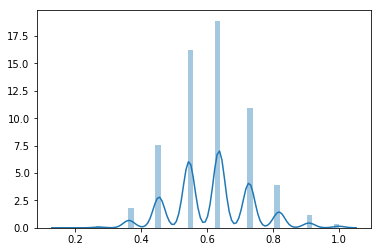

In [15]:
def fitnessTest(selection):
#     print(selection)
    score = 0
    
    score += 1 if selection.iloc[0, 3] == selection.iloc[1, 3] else 0 # cat_tree
    score += 1 if selection.iloc[0, 4] == selection.iloc[1, 4] else 0 # grade_level
    score += 1 if selection.iloc[0, 5] == selection.iloc[1, 5] else 0 # resource_cat
    score += 1 if np.absolute(selection.iloc[0, 6] - selection.iloc[1, 6]) <= 50 else 0 # cost
    score += 1 if selection.iloc[0, 7] == selection.iloc[1, 7] else 0 # status
    score += 1 if selection.iloc[0, 8] == selection.iloc[1, 8] else 0 # prefix
    score += 1 if selection.iloc[0, 10] == selection.iloc[1, 10] else 0 # metro_type
    score += 1 if np.absolute(selection.iloc[0, 11] - selection.iloc[1, 11]) <= 10 else 0 # free_lunch
    score += 1 if np.absolute(selection.iloc[0, 13] - selection.iloc[1, 13]) <= 500 else 0 # school_zip
    score += 1 if selection.iloc[0, 16] == selection.iloc[1, 16] else 0 # school_district
    
    a = selection.iloc[0, 19:].values
    b = selection.iloc[1, 19:].values
    score += 1 if np.absolute(b-a).sum() < 2 else 0 # subcats, must have at least one overlap subcat

    return score

results = []
for ixs in indices:
    results.append(fitnessTest(cat_break.loc[ixs]) / 11) # divide by 11 to normalize for maximum # of points

sns.distplot(results)
np.array(results).mean()

Above is the average fitness score for all pairs of similar projects. Below that is a distribution of fitness scores. We could do some simulation/test to see if 0.584 is significantly above chance or not.

Below is a search tree to find links of similar projects. Of 5000 indices, the longest chain of similar projects (i.e. the transitive property of similar projects... a=b, and b=c, thus a=c). Printed are siz projects that are found to be about the same based on this idea.

In [16]:
s_i = np.sort(indices, axis=1)

def search(link):
    try:
        nxt = s_i[s_i[:, 0] == link[-1]][0][1]
    except IndexError:
        return link
            
    if len(link) == 10:
        return link
    else:
        return search(np.append(link, nxt))
    
ixs = None

# loop through indices 0-4999 and search for trees that link from that index

for i in range(5000):
    try:
        ixs = search(s_i[s_i[:, 0] == i][0])
    except IndexError:
        continue
    
    if len(ixs) > 5:
        print('found 6 or more similar projects!')
        break

found 6 or more similar projects!


In [17]:
cat_break.loc[ixs]

,project_id,school_id,teacher_id,cat_tree,grade_level,resource_cat,cost,status,prefix,school_name,metro_type,free_lunch,school_state,school_zip,school_city,school_county,school_district,subcat_first,subcat_second,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth
313,e2334f6884a36b1b3462f93b546f7109,0c696f5277b3837734c2d532ceac8994,7bf46c02c0183f97942cd3f8eb6a7394,Math & Science,2,Supplies,426.85,1,1,George Sargeant Elementary School,3,45.0,California,95678,Roseville,Placer,Roseville City School District,Environmental Science,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1300,e5667f5106cd60fde7d2262a9f6e392a,f5b157d2fb9278a4ffc31b3bb24274dd,f3d4673651213840c87a980f5cfa3206,Math & Science,2,Art Supplies,489.61,1,1,Meadowlark Elementary School,1,31.0,California,93510,Acton,Los Angeles,Acton Agua Dulce Unif Sch Dist,Environmental Science,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1301,1078b68590638fe3839242be07f34c8f,f5b157d2fb9278a4ffc31b3bb24274dd,24bf715794b49f87b7a592bd017002f0,Math & Science,3,"Reading Nooks, Desks & Storage",393.21,1,1,Meadowlark Elementary School,1,31.0,California,93510,Acton,Los Angeles,Acton Agua Dulce Unif Sch Dist,Environmental Science,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1302,23e08d0884973e8c249a4a03f873aa5c,f5b157d2fb9278a4ffc31b3bb24274dd,10c6bab774ae9705f60a7207e12dbc8e,Math & Science,3,Technology,1890.29,1,1,Meadowlark Elementary School,1,31.0,California,93510,Acton,Los Angeles,Acton Agua Dulce Unif Sch Dist,Environmental Science,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
38361,00be2e75489873812927945dd4d546a0,dc184d26fda21b813ad705cd2669db79,0eee6a1b8e606a64719e90dc3c87156f,Math & Science,3,Supplies,1983.81,1,1,Ft Benton Elementary School,1,33.0,Montana,59442,Fort Benton,Chouteau,Ft Benton School District 1,Environmental Science,NaN,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42220,7b7cbd6dee10294f516a3251b36ed995,5c5db880b5cc3bf1ce7bdb2bd0fcbd44,a75b0e64789ae0d00b967a97ca29d6b1,"Math & Science, Special Needs",3,Technology,1392.62,1,1,Buffalo Island Central West Elementary School,1,48.0,Arkansas,72447,Monette,Craighead,Buffalo Island Ctl Sch Dist 40,Applied Sciences,Special Needs,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [18]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

In [19]:
def classic_mds_embed(dmat, n_components=2):
    '''
    Classic Multidimensional Scaling 
    
    Parameters
    ---------
    graph : networkx.Graph
        Weighted graph of cell groups
        
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities.
        
    Return
    ---------
    embed_pts
    
    dmat
    
    sorted_node_list
    '''
    
    if n_components <= 0 or int(n_components) != n_components:
        raise Exception('m must be a positive integer')
    if not np.allclose(dmat, dmat.T):
        raise Exception('D not symmetrical')

    D2 = np.power(dmat, 2)

    n = D2.shape[0]

    I = np.ones((n, n))

    J = np.eye(n) - (1/n * I)

    B = -J.dot(D2).dot(J)/2

    (eigvals, eigvecs) = np.linalg.eigh(B)

#   i = np.absolute(eigvals).argsort()[::-1][:self.m] # if eigenvalues need be sorted based on magnitude
    i = eigvals.argsort()[::-1][:n_components]
    L = np.diag(eigvals[i])

    E = eigvecs[:,i]
    
    embed_pts = E.dot(np.sqrt(L))
    
    return (embed_pts, dmat)

In [20]:
# mds = MDS(n_jobs=-2, dissimilarity='precomputed')
mx = 1000
# fitmds = mds.fit_transform(Y[:mx, :mx])
fitmds = classic_mds_embed(Y[:mx, :mx])[0]

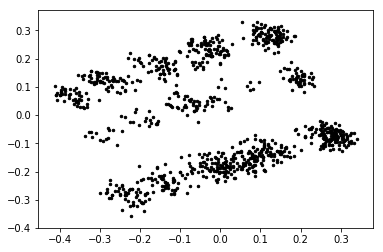

In [21]:
# c = cat_break.loc[:mx-1, 'cost'].values
# c = (c - min(c)) / max(c)
plt.scatter(fitmds[:, 0], fitmds[:, 1], c='k', s=6)

In [22]:
clust = KMeans(8)
fitclust = clust.fit_predict(fitmds)

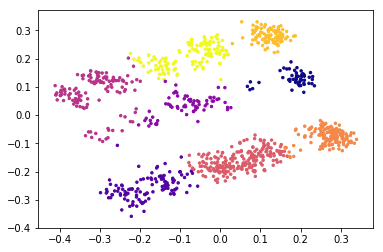

In [23]:
fitclust_norm = (fitclust - min(fitclust)) / max(fitclust)
plt.scatter(fitmds[:, 0], fitmds[:, 1], cmap='plasma', c=fitclust_norm, s=6)

In [24]:
# cat_break
locs = np.argwhere(fitclust_norm == 1)
cat_break.iloc[locs.flatten(), :]

,project_id,school_id,teacher_id,cat_tree,grade_level,resource_cat,cost,status,prefix,school_name,metro_type,free_lunch,school_state,school_zip,school_city,school_county,school_district,subcat_first,subcat_second,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth
14,eed6e8c9d7cc8915c395c74336496997,761a44947b32500b70f211c6f3eb8f5b,64dc7f5568c8806e6286d7836ebdd10a,Literacy & Language,3,Books,295.25,1,2,Gardner Academy,3,77.0,California,95125,San Jose,Santa Clara,San Jose Unified School Dist,Foreign Languages,Literacy,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
20,e852dcf1ff11f4fb24ae25f21712df8e,b93a860d527b1d8f7ffbfba77d2ddebd,d691f99a5d3596907c9fa7904fe7bc9c,"Literacy & Language, Math & Science",2,Supplies,558.40,1,0,PS 9 Teunis G Bergen,3,50.0,New York,11238,New York City,Kings (Brooklyn),New York City Dept Of Ed,Literacy,Mathematics,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
31,e8d6a186407921f58018716f91984308,b93a860d527b1d8f7ffbfba77d2ddebd,b57d7540d5adb91a0321ee87c51e26a4,"Special Needs, Music & The Arts",3,Supplies,286.75,1,0,PS 9 Teunis G Bergen,3,50.0,New York,11238,New York City,Kings (Brooklyn),New York City Dept Of Ed,Special Needs,Visual Arts,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
33,3fd7e2f3dff99abaeeff9bb4b3ca6146,b93a860d527b1d8f7ffbfba77d2ddebd,faca7d81eaf9b9245b04ab45f9963c8e,Literacy & Language,2,Flexible Seating,250.29,1,2,PS 9 Teunis G Bergen,3,50.0,New York,11238,New York City,Kings (Brooklyn),New York City Dept Of Ed,Literacy,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
89,007d5c24499bad3846694dec1536e99e,92378dc0cc5aa9277cad7bf61723c0ca,31c711e916bb51c00456a936aa1ea252,"Literacy & Language, Math & Science",2,Technology,633.80,1,1,Nichols Hills Elementary School,3,38.0,Oklahoma,73116,Oklahoma City,Oklahoma,Oklahoma City School Dist,Literacy,Mathematics,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
92,dfcba2bc5abbb9f6e00a4da814a670a5,f2224ab306473e427371e018eb3971d9,2e19358a877ec94334163a90f42e2e8a,"Literacy & Language, Math & Science",3,Computers & Tablets,366.44,1,0,Valhalla Elementary School,2,68.0,Washington,98001,Auburn,King,Federal Way School Dist 210,Literacy,Mathematics,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
104,2c4415ef0852b506e982a9f61ffeb053,744376ff23c1edbfdcf6e927fc6dc783,cb4007aeaa49bdf74689591a3cf2f4ad,"Math & Science, Literacy & Language",2,Supplies,496.65,0,1,McKinley-Brighton Magnet School,3,74.0,New York,13205,Syracuse,Onondaga,Syracuse City School District,Applied Sciences,Literacy,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
105,dbefa2d86a4618c7c53bec52dca6d3c2,744376ff23c1edbfdcf6e927fc6dc783,a5ae0b182d66c56ec616caa06f44a15c,Music & The Arts,2,Supplies,1052.61,0,0,McKinley-Brighton Magnet School,3,74.0,New York,13205,Syracuse,Onondaga,Syracuse City School District,Visual Arts,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
106,c97ab985600d44faf49c94473734d3fa,744376ff23c1edbfdcf6e927fc6dc783,979c0e695e34a057f87a2aaf97aeb0eb,Applied Learning,2,Supplies,391.74,1,1,McKinley-Brighton Magnet School,3,74.0,New York,13205,Syracuse,Onondaga,Syracuse City School District,Other,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
108,8cb85667daee8e65a36a85424d244a29,3b372b605a3be147ded643dd6ba2281b,7d79bbfcd008c8c28d41eff437b060db,Math & Science,2,Technology,325.79,1,1,John F Kennedy High School,2,83.0,Connecticut,6708,Waterbury,New Haven,Waterbury Public School Dist,Applied Sciences,